# 1. Download and Import Required Packages

In [1]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 9.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install -c conda-forge librosa

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::bleach==5.0.1=pyhd8ed1ab_0
  - conda-forge/noarch::pytest==7.2.0=pyhd8ed1ab_2
  - conda-forge/noarch::python-lsp-jsonrpc==1.0.0=pyhd8ed1ab_0
  - conda-forge/noarch::qtpy==2.3.0=pyhd8ed1ab_0
  - conda-forge/linux-64::sip==6.7.5=py310hd8f1fbe_0
  - conda-forge/noarch::terminado==0.17.1=pyh41d4057_0
  - conda-forge/linux-64::watchdog==2.2.1=py310hff52083_0
  - conda-forge/noarch::dask-core==2022.11.0=pyhd8ed1ab_0
  - conda-forge/noarch::flask==2.2.2=pyhd8ed1ab_0
  - conda-forge/noarch::importlib_metadata==6.0.0=hd8ed1ab_0
  - conda-forge/noarch::nltk==3.8.1=pyhd8ed1ab_0
  - conda-forge/linux-64::pyqt5-sip==12.11.0=py310hd8f1fbe_2
  - conda-forge/noarch::python-lsp-server-base==1.7.0=pyhd8ed1ab_0
  - conda-forge/noarch::pytoolconfig==1.2.4=pyhd8ed1ab_1
  - conda-forge/noarch::qdarkstyle==3.0.3=pyhd8ed1ab_0
  - conda-

certifi-2023.5.7     | 149 KB    | ##################################### | 100% 
lazy_loader-0.2      | 13 KB     | ##################################### | 100% 
soxr-0.1.3           | 128 KB    | ##################################### | 100% 
libsndfile-1.2.0     | 342 KB    | ##################################### | 100% 
cloudpickle-2.2.1    | 27 KB     | ##################################### | 100% 
soxr-python-0.3.5    | 259 KB    | ##################################### | 100% 
scikit-learn-1.2.2   | 7.3 MB    | ##################################### | 100% 
openh264-2.1.0       | 1.5 MB    | ##################################### | 100% 
pulseaudio-16.1      | 1.5 MB    | ##################################### | 100% 
botocore-1.29.144    | 5.8 MB    | ##################################### | 100% 
openssl-3.1.1        | 2.5 MB    | ##################################### | 100% 
ujson-5.7.0          | 50 KB     | ##################################### | 100% 
jupyter_server-1.23. | 238 K

In [29]:
import math
import boto3
import pickle
import keras_tuner
import numpy as np
import pandas as pd
import librosa as lr
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import sklearn.metrics as metrics

from IPython.display import HTML
from tensorflow.keras import Input
from sklearn.metrics import f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

# 2. Import and Convert Testing Data

In [4]:
def import_model(bucket, key):
    try:
        model = pickle.loads(s3.Bucket(bucket).Object(key).get()['Body'].read())
    except Exception as e:
        print(e)
    return model

In [5]:
def import_data(bucket, key):
    try:
        loaded_pickle = pickle.loads(s3.Bucket(bucket).Object(key).get()['Body'].read())
    except Exception as e:
        print(e)
    return loaded_pickle['X_train'], loaded_pickle['y_train'], loaded_pickle['X_test'], loaded_pickle['y_test']

In [6]:
def convert_to_melspectrogram(audio_files, sr, n_fft, hop_length, n_mels):
    audio_mel = lr.feature.melspectrogram(y = audio_files[0], sr = sr, n_fft = n_fft, hop_length = hop_length, n_mels = n_mels)
    audio_mel_dbd = lr.amplitude_to_db(abs(audio_mel), ref = np.max)
    shape_0 = audio_mel_dbd.shape[0]
    shape_1 = audio_mel_dbd.shape[1]
    audio_mel_dbd = np.reshape(audio_mel_dbd, [1, shape_0, shape_1])
    
    if len(audio_files) == 1:
        return audio_mel_dbd

    for file in audio_files[1:]:
        audio_mel_temp = lr.feature.melspectrogram(y = file, sr = sr, n_fft = n_fft, hop_length = hop_length, n_mels = n_mels)
        audio_mel_dbd_temp = lr.amplitude_to_db(abs(audio_mel_temp), ref = np.max)
        audio_mel_dbd = np.vstack([audio_mel_dbd, np.reshape(audio_mel_dbd_temp, [1, shape_0, shape_1])])
    return audio_mel_dbd

In [7]:
s3 = boto3.resource('s3')
bucket = 'pumpaudio-zach'

In [8]:
model_00 = import_model(bucket, 'models/model_00.pkl')
model_02 = import_model(bucket, 'models/model_02.pkl')
model_04 = import_model(bucket, 'models/model_04.pkl')
model_06 = import_model(bucket, 'models/model_06.pkl')

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-05-22 13:42:36           64
config.json                                    2023-05-22 13:42:36         3753
variables.h5                                   2023-05-22 13:42:36    113410704


2023-06-01 18:26:39.682263: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......flatten
.........vars
......input_layer
.........vars
......reshape
.........vars
...vars
Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-05-22 13:42:38           64
config.json                                    2023-05-22 13:42:38         3748
variables.h5                                   2023-05-22 13:42:38     42659216
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.

In [9]:
train00_X, train00_y, test00_X, test00_y = import_data(bucket, 'pump_raw/id_00.pkl')
train02_X, train02_y, test02_X, test02_y = import_data(bucket, 'pump_raw/id_02.pkl')
train04_X, train04_y, test04_X, test04_y = import_data(bucket, 'pump_raw/id_04.pkl')
train06_X, train06_y, test06_X, test06_y = import_data(bucket, 'pump_raw/id_06.pkl')

In [10]:
test00p_X = convert_to_melspectrogram(test00_X, 22050, 1024, 128, 64)
print('Test Pump 00 Audio Converted!')
test02p_X = convert_to_melspectrogram(test02_X, 22050, 1024, 256, 64)
print('Test Pump 02 Audio Converted!')
test04p_X = convert_to_melspectrogram(test04_X, 22050, 1024, 256, 64)
print('Test Pump 04 Audio Converted!')
test06p_X = convert_to_melspectrogram(test06_X, 22050, 1024, 256, 64)
print('Test Pump 06 Audio Converted!')

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/librosa/filters.py:245: RuntimeWarning: divide by zero encountered in true_divide
  enorm = 2.0 / (mel_f[2 : n_mels + 2] - mel_f[:n_mels])


Test Pump 00 Audio Converted!
Test Pump 02 Audio Converted!
Test Pump 04 Audio Converted!
Test Pump 06 Audio Converted!


# 3. Evaluating Tuned Models

In [21]:
baseline_predictions = []
reconstruction_errors_avg1 = []
reconstruction_errors_avg2 = []
for baseline in zip([model_00, model_02, model_04, model_06], [test00p_X, test02p_X, test04p_X, test06p_X]):
    predictions_temp = baseline[0].predict(baseline[1])
    baseline_predictions.append(predictions_temp)
    reconstruction_errors_avg1.append(np.mean(np.square(baseline[1] - predictions_temp), axis = 1))
    reconstruction_errors_avg2.append(np.mean(np.mean(np.square(baseline[1] - predictions_temp), axis = 1), axis = 1))

10/10 [==============================] - 0s 9ms/step


### Reconstruction Error

In [22]:
def plot_reconstruction(error, y , axs, class_label):
    
    axs.set_title('Reconstruction Error: ' + class_label)
    
    bin_width = 10
    bins = np.arange(min(error), max(error) + (4 * bin_width), bin_width)

    axs.hist(error[y == 0], bins = bins, label = 'Normal signals', color = 'blue', alpha = 0.2)
    axs.hist(error[y == 1], bins = bins, label = 'Abnormal signals', color = 'red', alpha = 0.2)
    
    axs.set_xlabel("Testing Reconstruction Error")
    axs.set_ylabel("# Samples")
    axs.legend()

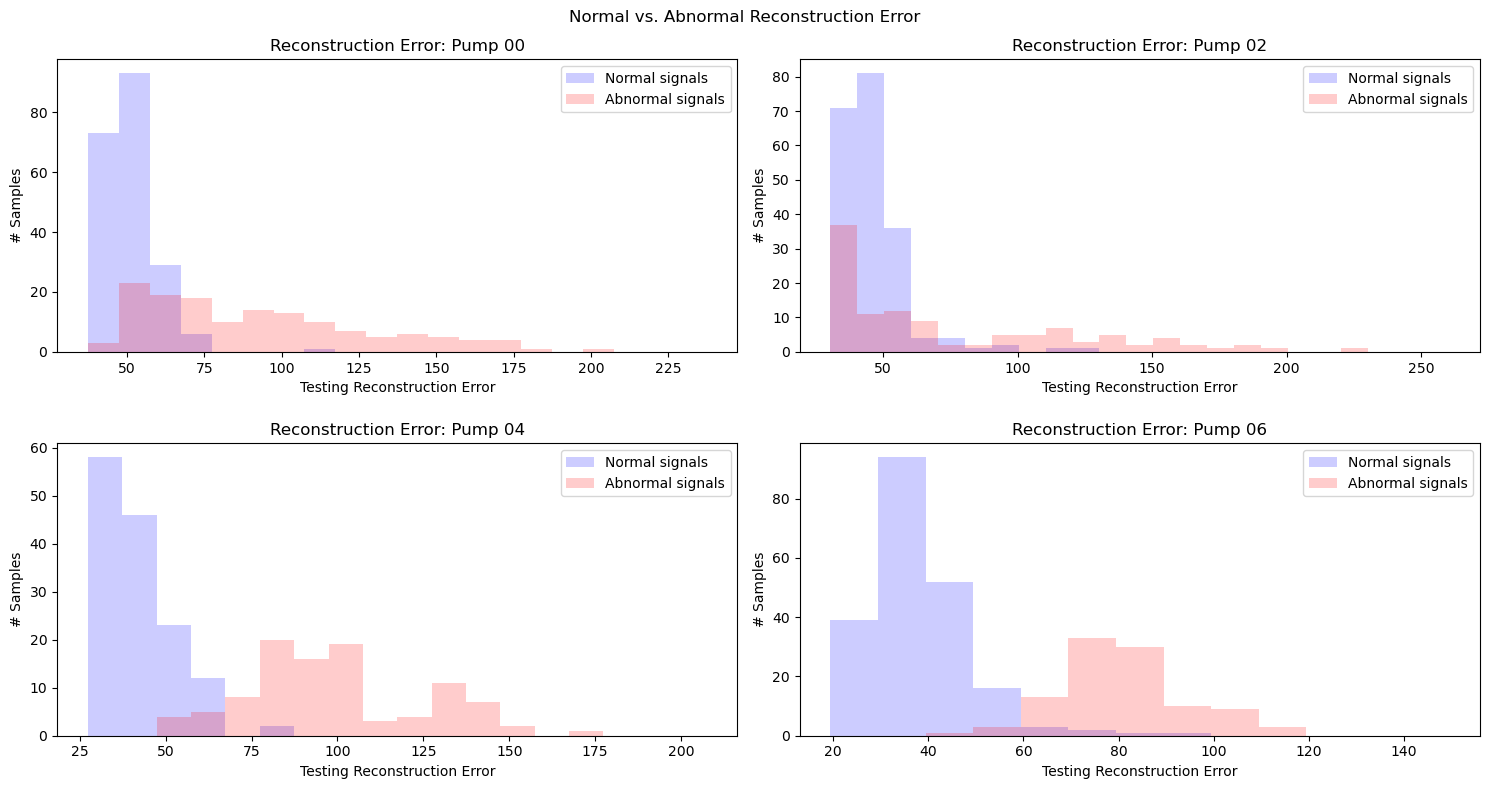

In [23]:
#standardize
figure, axes = plt.subplots(2, 2, figsize = (15, 8))

figure.suptitle('Normal vs. Abnormal Reconstruction Error')

plot_reconstruction(reconstruction_errors_avg2[0], test00_y, axes[0,0], 'Pump 00')
plot_reconstruction(reconstruction_errors_avg2[1], test02_y, axes[0,1], 'Pump 02')
plot_reconstruction(reconstruction_errors_avg2[2], test04_y, axes[1,0], 'Pump 04')
plot_reconstruction(reconstruction_errors_avg2[3], test06_y, axes[1,1], 'Pump 06')

figure.tight_layout(h_pad = 2)
plt.show()

### Setting Error Thresholds

In [24]:
def plot_F1(error, y, axs, class_label):
    
    axs.set_title('F1 vs. Threshold: ' + class_label)
    
    thresholds = np.arange(min(error), max(error) + 5, 5)
    
    f1 = []
    
    for threshold in thresholds:
        predictions = np.where(error < threshold, 0, 1)
        f1.append(f1_score(y, predictions))

    axs.plot(thresholds, f1)
    
    axs.set_xlabel("Reconstruction Error Threshold")
    axs.set_ylabel("Model F1")
    
    max_threshold = thresholds[f1 == max(f1)][0]
    print(class_label + ' Max F1: ' + str(max(f1)))
    print(class_label + ' Best Threshold: ' + str(max_threshold))
    print('\n')
    return max_threshold

Pump 00 Max F1: 0.8161764705882353
Pump 00 Best Threshold: 62.344139099121094


Pump 02 Max F1: 0.5948717948717949
Pump 02 Best Threshold: 55.393869400024414


Pump 04 Max F1: 0.9484536082474226
Pump 04 Best Threshold: 62.39793395996094


Pump 06 Max F1: 0.9468599033816426
Pump 06 Best Threshold: 59.43851280212402




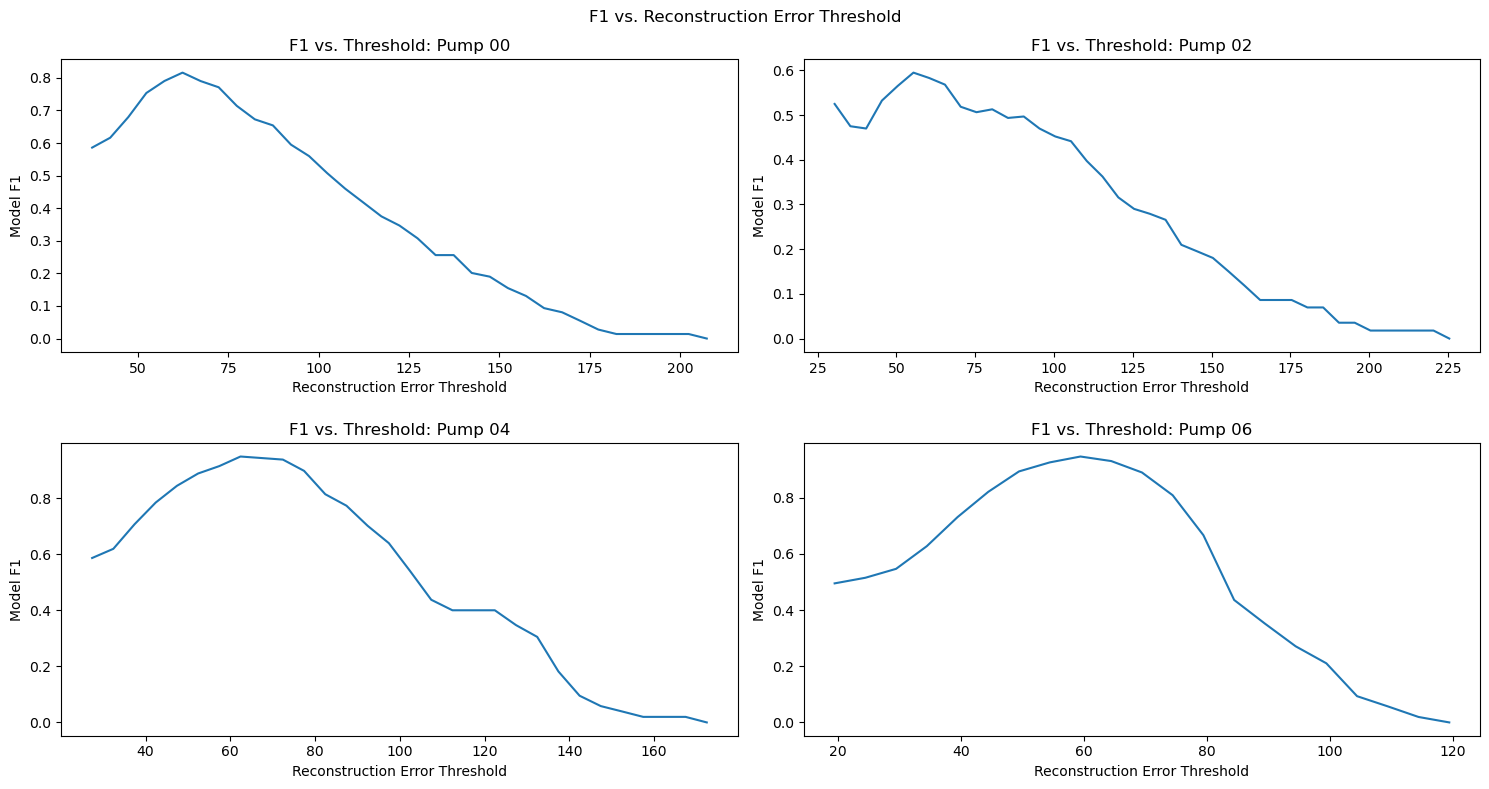

In [25]:
figure, axes = plt.subplots(2, 2, figsize = (15, 8))

figure.suptitle('F1 vs. Reconstruction Error Threshold')

max_threshold_00 = plot_F1(reconstruction_errors_avg2[0], test00_y, axes[0,0], 'Pump 00')
max_threshold_02 = plot_F1(reconstruction_errors_avg2[1], test02_y, axes[0,1], 'Pump 02')
max_threshold_04 = plot_F1(reconstruction_errors_avg2[2], test04_y, axes[1,0], 'Pump 04')
max_threshold_06 = plot_F1(reconstruction_errors_avg2[3], test06_y, axes[1,1], 'Pump 06')

figure.tight_layout(h_pad = 2)
plt.show()

### Confusion Matrix with Best Error Threshold

In [26]:
def print_stats(y_true, error, threshold, class_label):
    def get_predictions(error, threshold):
        return np.where(error < threshold, 0, 1)
    
    tn, fp, fn, tp = confusion_matrix(y_true, get_predictions(error, threshold)).ravel()
    
    print(class_label + ' True Negative: ' + str(tn))
    print(class_label + ' True Positive: ' + str(tp))
    print(class_label + ' False Negative: ' + str(fn))
    print(class_label + ' False Positive: ' + str(fp))
    
    return get_predictions(error, threshold)

In [27]:
pred_00 = print_stats(test00_y, reconstruction_errors_avg2[0], max_threshold_00, 'Pump 00')
print('\n')
pred_02 = print_stats(test02_y, reconstruction_errors_avg2[1], max_threshold_02, 'Pump 02')
print('\n')
pred_04 = print_stats(test04_y, reconstruction_errors_avg2[2], max_threshold_04, 'Pump 04')
print('\n')
pred_06 = print_stats(test06_y, reconstruction_errors_avg2[3], max_threshold_06, 'Pump 06')

Pump 00 True Negative: 184
Pump 00 True Positive: 111
Pump 00 False Negative: 32
Pump 00 False Positive: 18


Pump 02 True Negative: 175
Pump 02 True Positive: 58
Pump 02 False Negative: 53
Pump 02 False Positive: 26


Pump 04 True Negative: 139
Pump 04 True Positive: 92
Pump 04 False Negative: 8
Pump 04 False Positive: 2


Pump 06 True Negative: 201
Pump 06 True Positive: 98
Pump 06 False Negative: 4
Pump 06 False Positive: 7


### Plotting AUC

Pump 00: 
FPR: [0.         0.08910891 1.        ]
TPR: [0.         0.77622378 1.        ]


Pump 02: 
FPR: [0.         0.12935323 1.        ]
TPR: [0.         0.52252252 1.        ]


Pump 04: 
FPR: [0.        0.0141844 1.       ]
TPR: [0.   0.92 1.  ]


Pump 06: 
FPR: [0.         0.03365385 1.        ]
TPR: [0.         0.96078431 1.        ]




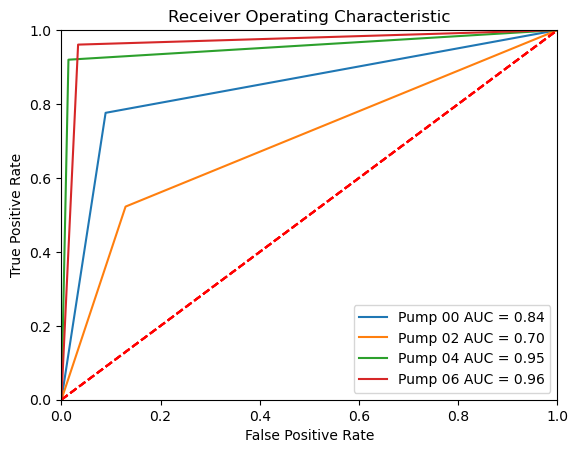

In [30]:
true = [test00_y, test02_y,test04_y, test06_y]
pred = [pred_00, pred_02, pred_04, pred_06]
class_labels = ['Pump 00', 'Pump 02', 'Pump 04', 'Pump 06']
auc_data = zip(true, pred, class_labels)
for data in auc_data:
    fpr, tpr, threshold = metrics.roc_curve(data[0], data[1])
    print(data[2] + ': ')
    print('FPR: ' + str(fpr))
    print('TPR: ' + str(tpr))
    print('\n')
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = data[2] + ' AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()

### Reconstruction Performance

In [31]:
def plot_heatmap(avg_error, axs, class_label):
    
    lr.display.specshow(avg_error, x_axis = 'time', y_axis = 'log', ax = axs)

    axs.set_title(class_label + ": Avg Error across Freqency and Time" + "\n")
    axs.set_xlabel("Time (Seconds)")
    axs.set_ylabel("Frequency (Hz)")

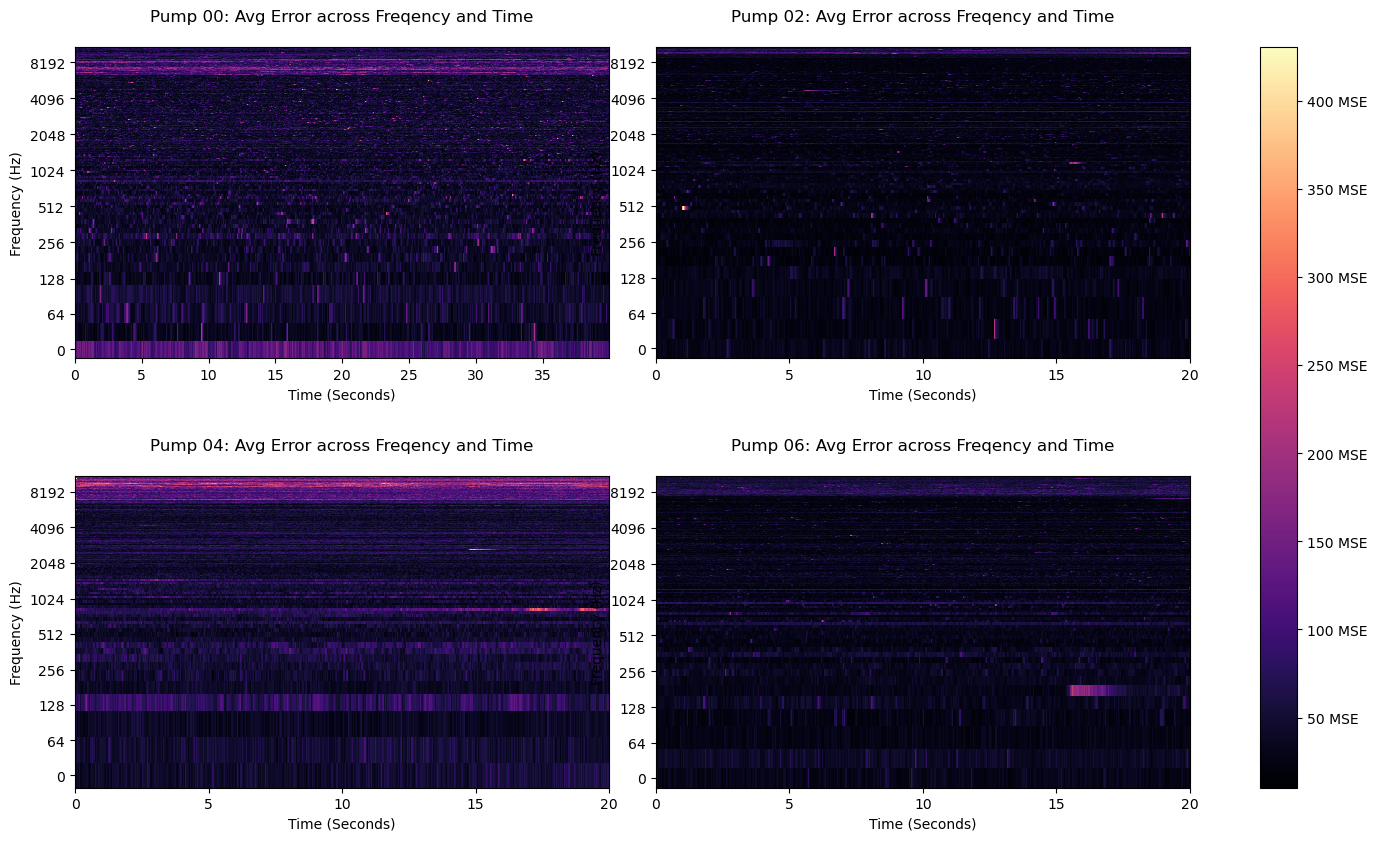

In [32]:
figure, axes = plt.subplots(2, 2, figsize = (15, 8))

img = lr.display.specshow(reconstruction_errors_avg1[0], x_axis = 'time', y_axis = 'log', ax = axes[0, 0])
figure.tight_layout(h_pad = 5)
figure.colorbar(img, ax = axes, format = "%2.f MSE")

plot_heatmap(reconstruction_errors_avg1[0], axes[0, 0], 'Pump 00')
plot_heatmap(reconstruction_errors_avg1[1], axes[0, 1], 'Pump 02')
plot_heatmap(reconstruction_errors_avg1[2], axes[1, 0], 'Pump 04')
plot_heatmap(reconstruction_errors_avg1[3], axes[1, 1], 'Pump 06')

plt.show()

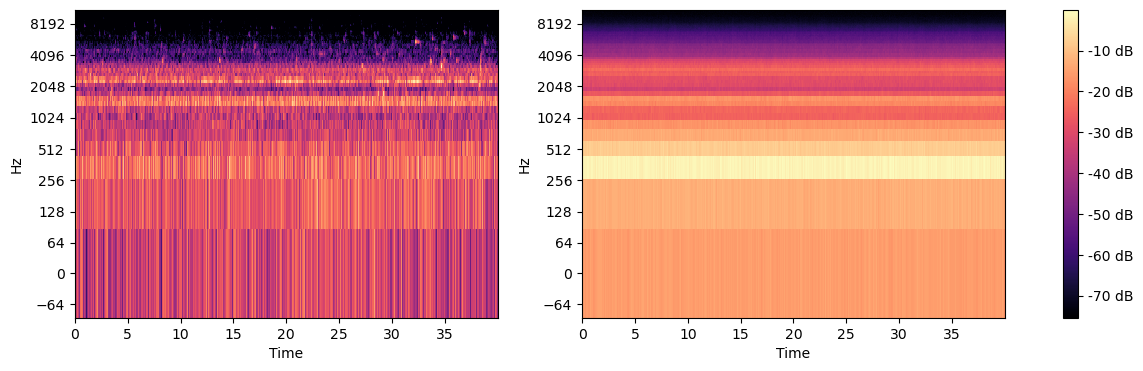

In [85]:
figure, axes = plt.subplots(1, 2, figsize = (15, 4), squeeze = False)

img = lr.display.specshow(test00p_X[-1], x_axis = 'time', y_axis = 'log', ax = axes[0, 0])

lr.display.specshow(baseline_predictions[0][-1], x_axis = 'time', y_axis = 'log', ax = axes[0, 1])

figure.colorbar(img, ax = axes, format = "%2.f dB")

plt.show()